Defining some utilitary functions and importing some modules

In [70]:
def query_TAP(tap_endpoint, adql_query, table_to_upload=None):
    """
    Query a TAP service (designated by its tap_endpoint)
    with a given ADQL query
    
    Query is performed synchronously
    
    Return an AstroPy Table object
    """
    import requests
    from astropy.table import Table
    from astropy.io.votable import parse_single_table
    import os
    import tempfile
    import warnings
    
    r = requests.post(tap_endpoint + '/sync', data={'query': adql_query, 'request': 'doQuery', 'lang': 'adql', 'format': 'votable', 'phase': 'run'})
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
    tmp_vot = tempfile.NamedTemporaryFile(delete = False)
    with open(tmp_vot.name, 'w') as h:
        for line in r.iter_lines():
            if line:
                h.write(line.decode(r.encoding)+'\n')

    table = parse_single_table(tmp_vot.name).to_table()

    # finally delete temp files
    os.unlink(tmp_vot.name)

    return table

from astroquery.xmatch import XMatch
import types
import six
from astropy.io import ascii

# monkey patching XMatch
def patched_is_table_available(self, table_id):
        if isinstance(table_id, six.string_types) and (table_id[:7] == 'vizier:'):
            table_id = table_id[7:]
        if not isinstance(table_id, six.string_types):
            return False
        
        return table_id in self.get_available_tables()
    
    
XMatch.is_table_available = types.MethodType(patched_is_table_available, XMatch)

    
from astropy import units as u

    
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

def plot_scatter_density(xdata, ydata, xlabel, ylabel, title, xlim=None, ylim=None, cmap='viridis', invert_yaxis = True, s=2, grid=False):
    from scipy.stats import gaussian_kde
    import numpy as np

    x = np.reshape(np.array(xdata, copy=False).astype('float'), (len(xdata)))
    y = np.reshape(np.array(ydata, copy=False).astype('float'), len(ydata))

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    
    
    
    w = h = 8
    fig, ax = plt.subplots(figsize = (w, h))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    if invert_yaxis:
        ax.invert_yaxis()
    ax.grid(grid)



# Query Gaia tables in VizieR

### Query table I/337/gaia

Let us query table I/337/gaia 20 arcmin around Messier 44

In [50]:
from astroquery.vizier import Vizier
result = Vizier.query_region('Messier 44', radius='0d20m0s', catalog='I/337/gaia')
print(result[0])


  _RAJ2000    _DEJ2000     _r    ...      ELON           ELAT     
    deg         deg       deg    ...      deg            deg      
----------- ----------- -------- ... -------------- --------------
130.1865314  19.3486212 0.328363 ... 127.5117262730   0.9888678171
130.1734120  19.3550861 0.319197 ... 127.4981014125   0.9919388024
130.1809087  19.3575670 0.318394 ... 127.5043015311   0.9961520570
130.1453588  19.3393683 0.330106 ... 127.4765479898   0.9699560692
130.1530759  19.3466008 0.323979 ... 127.4817313114   0.9788143258
130.1305209  19.3558631 0.312159 ... 127.4587835142   0.9823087783
130.1676459  19.3578603 0.315346 ... 127.4921305987   0.9932240029
130.1648495  19.3597605 0.312960 ... 127.4890925233   0.9943835979
130.1760724  19.3824866 0.293110 ... 127.4934939615   1.0190656351
130.1632544  19.3889285 0.284090 ... 127.4801523613   1.0221888630
        ...         ...      ... ...            ...            ...
130.3072612  19.9280474 0.326087 ... 127.4726532654   1.578051

By default, output is limited to 50 rows. Let's change this and redo the query.

In [53]:
Vizier.ROW_LIMIT = 100000
result = Vizier.query_region('Messier 44', radius='0d20m0s', catalog='I/337/gaia')
print(result[0]['RA_ICRS', 'DE_ICRS', 'Source', 'Plx'])

   RA_ICRS        DE_ICRS           Source       Plx
     deg            deg                          mas
-------------- -------------- ------------------ ---
130.1865313919  19.3486212439 661215094304448640  --
130.1734120176  19.3550860525 661215163021682304  --
130.1809086744  19.3575670451 661215163021683584  --
130.1453588017  19.3393683410 661215231741149824  --
130.1530758561  19.3466007875 661215266100770176  --
130.1305209099  19.3558630743 661215300460507904  --
130.1676459265  19.3578602741 661215369180114176  --
130.1648494742  19.3597605175 661215369180116096  --
130.1760723589  19.3824865661 661215472259347584  --
130.1632544126  19.3889284843 661215472259355008  --
           ...            ...                ... ...
130.3072612277  19.9280473548 661401362739275648  --
130.2779935036  19.9267150742 661401392804351616  --
130.2936865771  19.9351334294 661401427163456896  --
130.2921118352  19.9366005215 661401427164102144  --
130.2791825435  19.9420699604 6614015989621534

We add now a constraint to keep only sources with a parallax > 5 mas

In [54]:
result = Vizier(column_filters={"Plx":">5"}).query_region('Messier 44', radius='0d20m0s', catalog='I/337/gaia', )
print(result[0]['RA_ICRS', 'DE_ICRS', 'Source', 'Plx'])

   RA_ICRS        DE_ICRS           Source        Plx  
     deg            deg                           mas  
-------------- -------------- ------------------ ------
130.2344037741  19.5802836152 661246018066598656   5.14
130.4260703292  19.6604830268 661252993093483392   6.06
129.9905508004  19.5414242443 661268248817325312   5.58
129.7877457088  19.5923409653 661284019938140032   6.12
130.0752439503  19.5319393680 661290754445957248   5.65
130.1123817124  19.5447617762 661291132403077760   5.38
130.0918665674  19.6698786868 661297076637809024   5.37
130.1798638364  19.7192651397 661300546971382016   5.22
130.2943301698  19.8294836433 661305838371084288   5.80
129.9275637670  19.7784005964 661311439008441600   5.19
130.0976146683  19.8349117737 661316902206838528   6.69
130.2370701390  19.9347999163 661319547906689024   5.60
130.0637997945  19.9942491067 661323636715553152   5.13
130.3072283373  19.9219407004 661401358443742720   5.93


Send result to VO tools through SAMP

### Query RRLyrae table and retrieve a light curve

Retrieve list of RRLyrae and sort it by period

In [65]:
rrlyrae = Vizier.get_catalogs(catalog='I/337/rrlyrae')[0]
rrlyrae.sort('P1')
print(rrlyrae['Source', 'P1', 'RA_ICRS', 'DE_ICRS'])

       Source            P1        RA_ICRS        DE_ICRS    
                         d           deg            deg      
------------------- ----------- -------------- --------------
4660711867541110784  0.21271385  84.0752731841 -65.7055413718
4660748774181753856  0.22183517  82.6928520423 -65.6441506678
5284152449583643648  0.22921618  90.3248461932 -66.8247183205
4663058229629271168  0.23316532  73.6300760013 -65.5173344610
5283973538437208320  0.23487892  91.7268314090 -66.8423299446
4662090178378689408  0.23565586  74.8057550936 -66.8600788745
4662010395066656384  0.23665484  77.0341004548 -66.4998070287
4663521502000875136  0.23766071  78.9541272098 -65.8416381584
4663686256931717376  0.23839866  78.2212926200 -64.6919818517
5276543829112460800  0.23944377 127.4767181695 -64.5756518278
                ...         ...            ...            ...
4675028024310945920  0.81744992  65.5170999930 -65.4086251949
4663900764773575680  0.82574879  76.6177392905 -64.8764986300
46634982

/Users/thomas/anaconda3/lib/python3.5/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


Retrieve light curve points for Source = 4660711867541110784

In [68]:
lc_points = Vizier(column_filters={"Source":"4660711867541110784"}).get_catalogs(catalog='I/337/fov')[0]
print(lc_points['ObsTime', 'FG'])

ObsTime        FG      
   d          e-/s     
------- ---------------
1687.99       480.50937
1688.24       491.64636
1688.49       437.73251
1688.74       395.67110
1688.99       404.05778
1689.24       404.28456
1689.49       495.58290
1689.74       475.91021
1689.99       418.01522
1690.24       394.27661
    ...             ...
1694.42       468.96957
1694.49       372.29648
1694.67       416.21899
1694.99       428.27182
1737.04       395.92665
1737.11       458.84048
1859.97       401.80493
1894.44       394.53520
1957.23       377.17774
1985.22       431.99535
Length = 39 rows


Plot the light curve

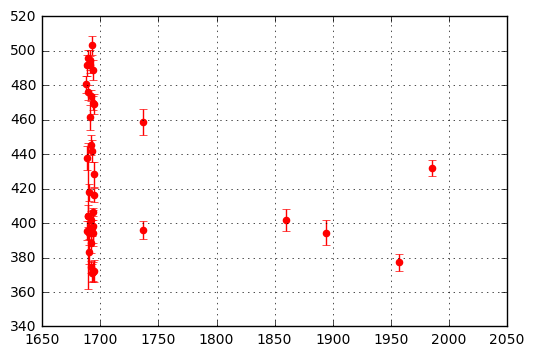

In [76]:
x = lc_points['ObsTime']
y = lc_points['FG']
y_err = lc_points['e_FG']
plt.scatter(x, y, color='r')
plt.errorbar(x, y, yerr=y_err, color='r', linestyle='None')
plt.grid(True)


Fold the light curve, folded by the period (P1 = 0.21271385 d)

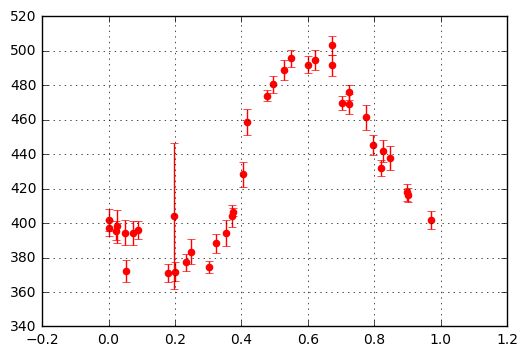

In [91]:
period = 0.21271385
#(time+8)%16 - 8
x = (lc_points['ObsTime'] % period) / period
y = lc_points['FG']
y_err = lc_points['e_FG'] 
plt.scatter(x, y, color='r')
plt.errorbar(x, y, yerr=y_err, color='r', linestyle='None')
plt.grid(True)


# Query SIMBAD to retrieve stars member of a cluster and cross-match with TGAS

In [12]:
stars_in_cluster = query_TAP('http://simbad.u-strasbg.fr/simbad/sim-tap', 
                             """SELECT  ra, dec, pmra, pmdec, plx_value, plx_err FROM basic where otype_txt = '*iC'
                              and plx_value>1 and plx_value/plx_err > 5""")
print(stars_in_cluster)

        ra                 dec         ...     plx_value       plx_err  
       deg                 deg         ...        mas            mas    
------------------ ------------------- ... ------------------ ----------
161.56899012567726   -64.5145598145577 ... 6.8499999999999996 0.20999999
 48.34947130671857  48.176952442309371 ... 8.5800000000000001       0.37
 54.77802151852503  24.702873017617172 ... 8.3200000000000003 0.79000002
184.81643444292581  25.060243297651738 ... 6.4199999999999999 0.66000003
75.203695332014647  4.7331138426158796 ... 18.379999999999999  1.9400001
122.95071415191404 -12.678799803611035 ... 5.4800000000000004       1.02
52.777374097403595  50.481493286870879 ... 7.5800000000000001 0.55000001
128.83102340404923  19.590065306504904 ... 4.9299999999999997 0.55000001
141.84548228553999 -36.880150079571493 ... 8.2799999999999994 0.73000002
 188.8286403392454  36.338270781398741 ... 9.3300000000000001 0.93000001
               ...                 ... ...         

We now query the xmatch service to find counterparts in TGAS (max search radius: 1 arcsec)

In [26]:
xmatch_result = XMatch.query(cat1 = stars_in_cluster,
                             cat2 = 'vizier:I/337/tgasptyc',
                             max_distance = 1 * u.arcsec,                             
                             colRA1 = 'ra',
                             colDec1= 'dec', cache=False)

print(xmatch_result['ra', 'dec', 'plx_value', 'Plx', 'plx_err', 'e_Plx'])


      ra         RA_ICRS         dec       ...  Plx     plx_err     e_Plx
------------- ------------- -------------- ... ----- -------------- -----
48.3494713067 48.3495709535  48.1769524423 ...  9.97 0.370000004768  0.46
184.816434443 184.816561797  25.0602432977 ...  6.24 0.660000026226  0.45
 75.203695332 75.2039971193  4.73311384262 ... 19.25  1.94000005722  0.24
122.950714152 122.950702391 -12.6787998036 ...  3.21  1.01999998093  0.26
52.7773740974 52.7771573668  50.4814932869 ...  6.64 0.550000011921   0.3
128.831023404 128.830872847  19.5900653065 ...  5.24 0.550000011921  0.41
141.845482286 141.845561867 -36.8801500796 ...  8.54 0.730000019073  0.26
188.828640339 188.828142739  36.3382707814 ...   9.4 0.930000007153  0.27
189.165494777 189.165555076   25.791543079 ...  7.55  1.25999999046   0.3
182.340266498 182.340085293  29.4606042955 ...  4.97 0.730000019073  0.26
          ...           ...            ... ...   ...            ...   ...
147.795155141 147.795012773 -53.182982

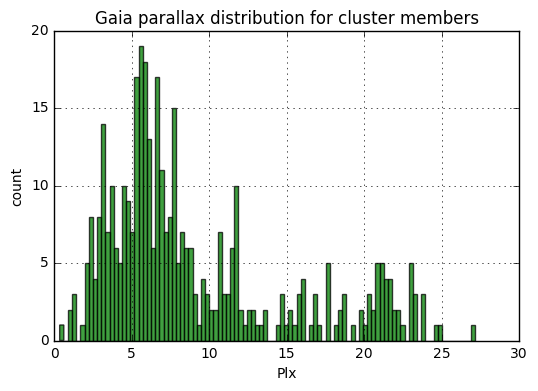

In [14]:
histvals, binvals, patches = plt.hist(xmatch_result['Plx'], bins=100, facecolor='g', alpha=0.75)

plt.xlabel('Plx')
plt.ylabel('count')
plt.title('Gaia parallax distribution for cluster members')
plt.grid(True)

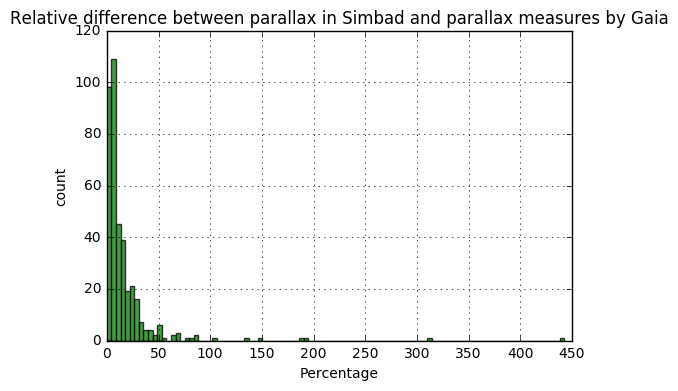

In [16]:
histvals, binvals, patches = plt.hist(100 * abs(xmatch_result['Plx'] - xmatch_result['plx_value']) / xmatch_result['Plx'], bins=100, facecolor='g', alpha=0.75)

plt.xlabel('Percentage')
plt.ylabel('count')
plt.title('Relative difference between parallax in Simbad and parallax measures by Gaia')
plt.grid(True)

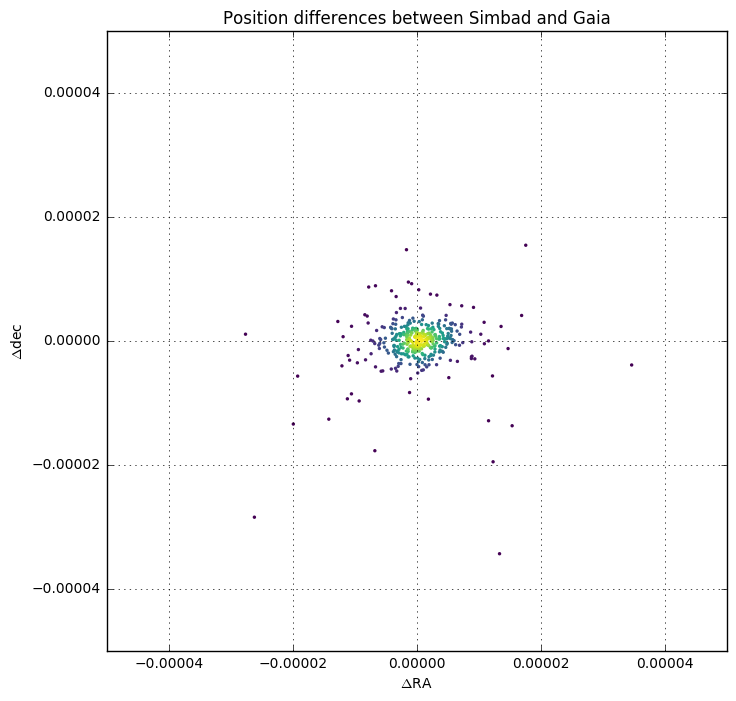

In [44]:
plot_scatter_density(xmatch_result['ra'] - xmatch_result['_RAJ2000'],
                     xmatch_result['dec']  - xmatch_result['_DEJ2000'],
                     r'$\Delta$RA', r'$\Delta$dec', 'Position differences between Simbad and Gaia', xlim=[-5e-5, 5e-5], ylim=[-5e-5, 5e-5],
                     cmap='viridis', invert_yaxis = False, s=6, grid=True)

